### CREDIT

This notebook is prepared by the guidance of Jesús Martínez's book, which is Tensorflow 2.0 Computer Vision Cookbook. Most of the code blocks and explanations are taken from this book. You can reach original codes and detailed explanations from book or from github repo of the book (https://github.com/PacktPublishing/Tensorflow-2.0-Computer-Vision-Cookbook).

#### WHAT IS THIS NOTEBOOK

This notebook is an example about CycleGAN to convert pictures of Yosemite National Park taken during the summer into their winter by keras and TF.

You can check book for details (Chapter 6, recipe-4)

#### Keywords

* CycleGAN
* image-to-image translation
* GAN
* TF
* cyclegan/summer2winter_yosemite dataset

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
def random_crop(image):
    return tf.image.random_crop(image, size=(256, 256, 3))


def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1

    return image


def random_jitter(image):
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
    image = tf.image.resize(image, (286, 286), method=method)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image


def preprocess_training_image(image):
    image = random_jitter(image)
    image = normalize(image)
    return image


def preprocess_test_image(image):
    image = normalize(image)
    return image


def generate_images(model, test_input, epoch):
    prediction = model(test_input)

    image = np.hstack([test_input[0], prediction[0]])
    image *= 0.5
    image += 0.5
    image *= 255.0
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.imwrite(f'{epoch + 1}.jpg', image)

In [3]:
class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        init = tf.random_normal_initializer(1.0, 0.02)
        self.scale = self.add_weight(name='scale',
                                     shape=input_shape[-1:],
                                     initializer=init,
                                     trainable=True)

        self.offset = self.add_weight(name='offset',
                                      shape=input_shape[-1:],
                                      initializer='zeros',
                                      trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x,
                                       axes=(1, 2),
                                       keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv

        return self.scale * normalized + self.offset

In [4]:
class CycleGAN(object):
    def __init__(self, output_channels=3, lambda_value=10):
        self.output_channels = output_channels
        self._lambda = lambda_value
        self.loss = BinaryCrossentropy(from_logits=True)

        self.gen_g = self.create_generator()
        self.gen_f = self.create_generator()

        self.dis_x = self.create_discriminator()
        self.dis_y = self.create_discriminator()

        self.gen_g_opt = Adam(learning_rate=2e-4, beta_1=0.5)
        self.gen_f_opt = Adam(learning_rate=2e-4, beta_1=0.5)

        self.dis_x_opt = Adam(learning_rate=2e-4, beta_1=0.5)
        self.dis_y_opt = Adam(learning_rate=2e-4, beta_1=0.5)

    @staticmethod
    def downsample(filters, size, norm=True):
        initializer = tf.random_normal_initializer(0.0, 0.02)

        layers = Sequential()
        layers.add(Conv2D(filters=filters,
                          kernel_size=size,
                          strides=2,
                          padding='same',
                          kernel_initializer=initializer,
                          use_bias=False))

        if norm:
            layers.add(InstanceNormalization())

        layers.add(LeakyReLU())

        return layers

    @staticmethod
    def upsample(filters, size, dropout=False):
        init = tf.random_normal_initializer(0.0, 0.02)

        layers = Sequential()
        layers.add(Conv2DTranspose(filters=filters,
                                   kernel_size=size,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer=init,
                                   use_bias=False))

        layers.add(InstanceNormalization())

        if dropout:
            layers.add(Dropout(rate=0.5))

        layers.add(ReLU())

        return layers

    def create_generator(self):
        down_stack = [
            self.downsample(64, 4, norm=False),
            self.downsample(128, 4),
            self.downsample(256, 4)]

        for _ in range(5):
            down_block = self.downsample(512, 4)
            down_stack.append(down_block)

        up_stack = []
        for _ in range(3):
            up_block = self.upsample(512, 4, dropout=True)
            up_stack.append(up_block)

        for filters in (512, 256, 128, 64):
            up_block = self.upsample(filters, 4)
            up_stack.append(up_block)

        inputs = Input(shape=(None, None, 3))
        x = inputs

        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = Concatenate()([x, skip])

        init = tf.random_normal_initializer(0.0, 0.02)
        output = Conv2DTranspose(
            filters=self.output_channels,
            kernel_size=4,
            strides=2,
            padding='same',
            kernel_initializer=init,
            activation='tanh')(x)

        return Model(inputs, outputs=output)

    def generator_loss(self, generated):
        return self.loss(tf.ones_like(generated), generated)

    def create_discriminator(self):
        input = Input(shape=(None, None, 3))
        x = input

        x = self.downsample(64, 4, False)(x)
        x = self.downsample(128, 4)(x)
        x = self.downsample(256, 4)(x)

        x = ZeroPadding2D()(x)

        init = tf.random_normal_initializer(0.0, 0.02)
        x = Conv2D(filters=512,
                   kernel_size=4,
                   strides=1,
                   kernel_initializer=init,
                   use_bias=False)(x)
        x = InstanceNormalization()(x)

        x = LeakyReLU()(x)
        x = ZeroPadding2D()(x)
        output = Conv2D(filters=1,
                        kernel_size=4,
                        strides=1,
                        kernel_initializer=init)(x)

        return Model(inputs=input, outputs=output)

    def discriminator_loss(self, real, generated):
        real_loss = self.loss(tf.ones_like(real), real)
        generated_loss = self.loss(tf.zeros_like(generated),
                                   generated)

        total_discriminator_loss = real_loss + generated_loss
        return total_discriminator_loss * 0.5

    def calculate_cycle_loss(self, real_image, cycled_image):
        error = real_image - cycled_image
        loss1 = tf.reduce_mean(tf.abs(error))
        return self._lambda * loss1

    def identity_loss(self, real_image, same_image):
        error = real_image - same_image
        loss = tf.reduce_mean(tf.abs(error))
        return self._lambda * 0.5 * loss

    @tf.function
    def train_step(self, real_x, real_y):
        with tf.GradientTape(persistent=True) as tape:
            # G translates X to Y
            # F translates Y to X.
            fake_y = self.gen_g(real_x, training=True)
            cycled_x = self.gen_f(fake_y, training=True)

            fake_x = self.gen_f(real_y, training=True)
            cycled_y = self.gen_g(fake_x, training=True)

            # same_x and same_y are used for identity loss
            same_x = self.gen_f(real_x, training=True)
            same_y = self.gen_g(real_y, training=True)

            dis_real_x = self.dis_x(real_x, training=True)
            dis_real_y = self.dis_y(real_y, training=True)
            dis_fake_x = self.dis_x(fake_x,training=True)
            dis_fake_y = self.dis_y(fake_y, training=True)

            # Compute the loss
            gen_g_loss = self.generator_loss(dis_fake_y)
            gen_f_loss = self.generator_loss(dis_fake_x)

            cycle_x_loss = \
                self.calculate_cycle_loss(real_x, cycled_x)
            cycle_y_loss = \
                self.calculate_cycle_loss(real_y, cycled_y)
            total_cycle_loss = cycle_x_loss + cycle_y_loss

            # Total generator loss = adversarial loss + cycle loss
            identity_y_loss = \
                self.identity_loss(real_y, same_y)
            total_generator_g_loss = (gen_g_loss +
                                      total_cycle_loss +
                                      identity_y_loss)

            identity_x_loss = \
                self.identity_loss(real_x, same_x)
            total_generator_f_loss = (gen_f_loss +
                                      total_cycle_loss +
                                      identity_x_loss)

            dis_x_loss = \
                self.discriminator_loss(dis_real_x, dis_fake_x)
            dis_y_loss = \
                self.discriminator_loss(dis_real_y, dis_fake_y)

        # Calculate the gradients for generator and discriminator.
        gen_g_grads = tape.gradient(
            total_generator_g_loss,
            self.gen_g.trainable_variables)
        gen_f_grads = tape.gradient(
            total_generator_f_loss,
            self.gen_f.trainable_variables)

        dis_x_grads = tape.gradient(
            dis_x_loss,
            self.dis_x.trainable_variables)
        dis_y_grads = tape.gradient(
            dis_y_loss,
            self.dis_y.trainable_variables)

        # Apply the gradients to the optimizer
        gen_g_opt_params = zip(gen_g_grads,
                               self.gen_g.trainable_variables)
        self.gen_g_opt.apply_gradients(gen_g_opt_params)

        gen_f_opt_params = zip(gen_f_grads,
                               self.gen_f.trainable_variables)
        self.gen_f_opt.apply_gradients(gen_f_opt_params)

        dis_x_opt_params = zip(dis_x_grads,
                               self.dis_x.trainable_variables)
        self.dis_x_opt.apply_gradients(dis_x_opt_params)

        dis_y_opt_params = zip(dis_y_grads,
                               self.dis_y.trainable_variables)
        self.dis_y_opt.apply_gradients(dis_y_opt_params)

    def fit(self, train, epochs, test):
        for epoch in tqdm(range(epochs)):
            for image_x, image_y in train:
                self.train_step(image_x, image_y)

            test_image = next(iter(test))
            generate_images(self.gen_g, test_image, epoch)

In [5]:
dataset, _ = tfds.load('cycle_gan/summer2winter_yosemite', with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/126 [00:01<?, ? MiB/s]

Extraction completed...: 0 file [00:01, ? file/s]
Dl Size...:   1%|          | 1/126 [00:03<06:53,  3.31s/ MiB]

Extraction completed...: 0 file [00:03, ? file/s]
Dl Size...:   2%|▏         | 2/126 [00:04<03:43,  1.80s/ MiB]

Extraction completed...: 0 file [00:04, ? file/s]
Dl Size...:   2%|▏         | 3/126 [00:04<02:47,  1.36s/ MiB]

Extraction completed...: 0 file [00:04, ? file/s]
Dl Size...:   3%|▎         | 4/126 [00:05<02:19,  1.14s/ MiB]

Extraction completed...: 0 file [00:05, ? file/s]
Dl Size...:   4%|▍         | 5/126 [00:06<01:57,  1.03 MiB/s]

Extraction completed...: 0 file [00:06, ? file/s]
Dl Size...:   5%|▍         | 6/126 [00:07<01:43,  1.16 MiB/s]

Extraction completed...: 0 file [00:07, ? file/s]
Dl Size...:   6%|▌         | 7/126 [00:07<01:39,

Dl Size...:  33%|███▎      | 42/126 [00:22<00:21,  3.95 MiB/s]

Extraction completed...: 0 file [00:22, ? file/s]
Dl Size...:  34%|███▍      | 43/126 [00:23<00:21,  3.83 MiB/s]

Extraction completed...: 0 file [00:23, ? file/s]
Dl Size...:  35%|███▍      | 44/126 [00:23<00:21,  3.80 MiB/s]

Extraction completed...: 0 file [00:23, ? file/s]
Dl Size...:  36%|███▌      | 45/126 [00:23<00:20,  3.97 MiB/s]

Extraction completed...: 0 file [00:23, ? file/s]
Dl Size...:  37%|███▋      | 46/126 [00:23<00:19,  4.17 MiB/s]

Extraction completed...: 0 file [00:23, ? file/s]
Dl Size...:  37%|███▋      | 47/126 [00:24<00:17,  4.54 MiB/s]

Extraction completed...: 0 file [00:24, ? file/s]
Dl Size...:  38%|███▊      | 48/126 [00:24<00:16,  4.79 MiB/s]

Extraction completed...: 0 file [00:24, ? file/s]
Dl Size...:  39%|███▉      | 49/126 [00:24<00:15,  4.90 MiB/s]

Extraction completed...: 0 file [00:24, ? file/s]
Dl Size...:  40%|███▉      | 50/126 [00:24<00:14,  5.15 MiB/s]

Extraction completed...:

Dl Size...:  68%|██████▊   | 86/126 [00:30<00:06,  5.76 MiB/s]

Extraction completed...: 0 file [00:30, ? file/s]
Dl Size...:  69%|██████▉   | 87/126 [00:31<00:06,  5.70 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:  70%|██████▉   | 88/126 [00:31<00:05,  6.33 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:  71%|███████   | 89/126 [00:31<00:06,  6.09 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:  71%|███████▏  | 90/126 [00:31<00:05,  6.62 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:  72%|███████▏  | 91/126 [00:31<00:05,  6.35 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:  73%|███████▎  | 92/126 [00:31<00:04,  6.90 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:  74%|███████▍  | 93/126 [00:32<00:05,  6.48 MiB/s]

Extraction completed...: 0 file [00:32, ? file/s]
Dl Size...:  75%|███████▍  | 94/126 [00:32<00:05,  5.73 MiB/s]

Extraction completed...:

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:37<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:38<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:39<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:40<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:41<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:42<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:43<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:44<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:45<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:46<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:47<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:48<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:49<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:50<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:51<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|██████████| 126/126 [00:52<00:00,  6.97 MiB/s]

Dl Size...: 100%|████████

ExtractError: Error while extracting C:\Users\Zeki\tensorflow_datasets\downloads\peop.eecs.berk.edu_taes_park_Cycl_data_sumFn_hcmgHqdIr0Qa0psC9eVO2iK-SSsG_lnQ5xJYeSfk.zip to C:\Users\Zeki\tensorflow_datasets\downloads\extracted\ZIP.peop.eecs.berk.edu_taes_park_Cycl_data_sumFn_hcmgHqdIr0Qa0psC9eVO2iK-SSsG_lnQ5xJYeSfk.zip: Failed to create a NewWriteableFile: C:\Users\Zeki\tensorflow_datasets\downloads\extracted\ZIP.peop.eecs.berk.edu_taes_park_Cycl_data_sumFn_hcmgHqdIr0Qa0psC9eVO2iK-SSsG_lnQ5xJYeSfk.zip.incomplete_50b2e2df917f4602bee18243ac3f31b2\summer2winter_yosemite\trainB\2011-06-06 15:15:24.jpg : The filename, directory name, or volume label syntax is incorrect.
; no protocol option

#### Because of the loading error, I will manually load images and convert it to tensorslice to follow rest of the code blocks as in the book !!!

In [23]:
from numpy import asarray
import os
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
def load_images(path, size=(256,256)):
    data_list = list()
# enumerate filenames in directory, assume all are images
    for filename in listdir(path):
# load and resize the image
        filename=os.path.join(path,filename)
        pixels = load_img(filename, target_size=size)
# convert to numpy array
        pixels = img_to_array(pixels)
# store
        data_list.append(pixels)
    return asarray(data_list)

In [24]:
path_trainA= r'Newfolder\trainA'
train_summer = load_images(path_trainA)


In [27]:
train_summer.shape

(1231, 256, 256, 3)

In [28]:
path_trainB= r'Newfolder\trainB'
train_winter = load_images(path_trainB)

path_testA= r'Newfolder\testA'
test_summer = load_images(path_testA)

path_testB= r'Newfolder\testB'
test_winter = load_images(path_testB)

In [29]:

BUFFER_SIZE = 400
BATCH_SIZE = 1


In [36]:
training_data = tf.data.Dataset.from_tensor_slices(train_summer)

In [39]:
train_summer = (training_data
                .map(preprocess_training_image,
                     num_parallel_calls=AUTOTUNE)
                .cache()
                .shuffle(BUFFER_SIZE)
                .batch(BATCH_SIZE))

In [41]:
training_winter = tf.data.Dataset.from_tensor_slices(train_winter)
train_winter = (training_winter
                .map(preprocess_training_image,
                     num_parallel_calls=AUTOTUNE)
                .cache()
                .shuffle(BUFFER_SIZE)
                .batch(BATCH_SIZE))

testing_summer = tf.data.Dataset.from_tensor_slices(test_summer)
test_summer = (testing_summer
               .map(preprocess_test_image,
                    num_parallel_calls=AUTOTUNE)
               .cache()
               .shuffle(BUFFER_SIZE)
               .batch(BATCH_SIZE))


testing_winter = tf.data.Dataset.from_tensor_slices(test_winter)
test_winter = (testing_winter
               .map(preprocess_test_image,
                    num_parallel_calls=AUTOTUNE)
               .cache()
               .shuffle(BUFFER_SIZE)
               .batch(BATCH_SIZE))

In [42]:
train_winter

<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>

In [43]:
cycle_gan = CycleGAN()
train_ds = tf.data.Dataset.zip((train_summer, train_winter))

In [44]:
cycle_gan.fit(train=train_ds, epochs=40,test=test_summer)

  8%|▊         | 3/40 [31:18<6:26:12, 626.28s/it]


KeyboardInterrupt: 

It will take 6 hours to finish... So I interupt training..

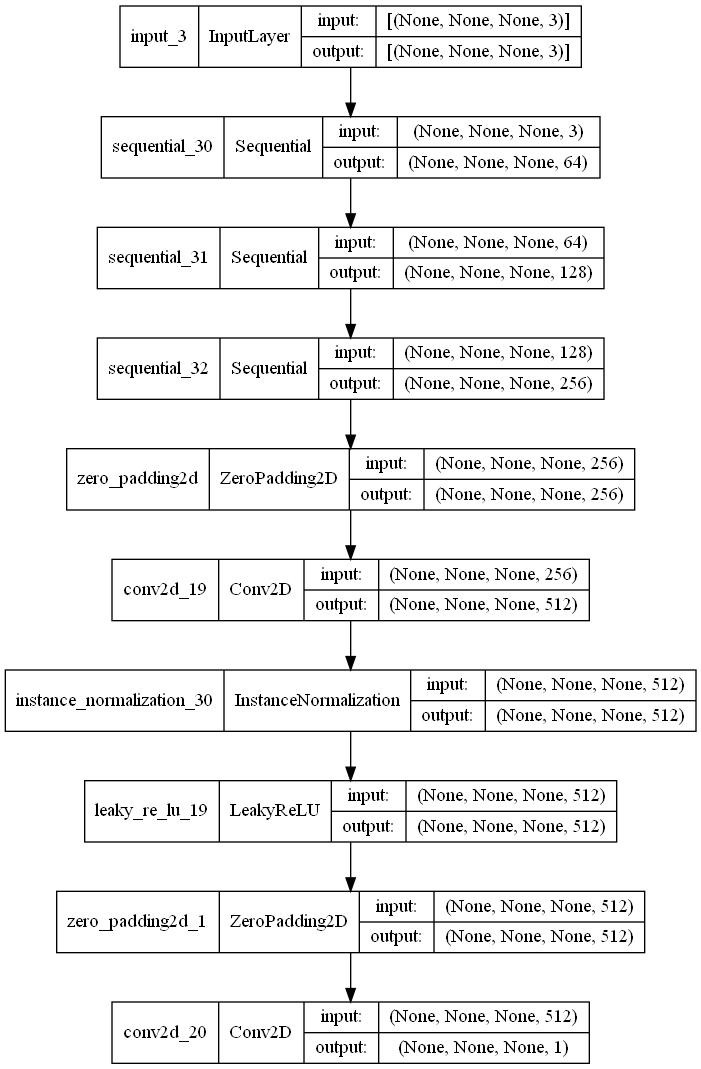

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(cycle_gan.dis_x, show_shapes=True, show_layer_names=True, to_file='cycle_gan.dis_x_summer.jpg')

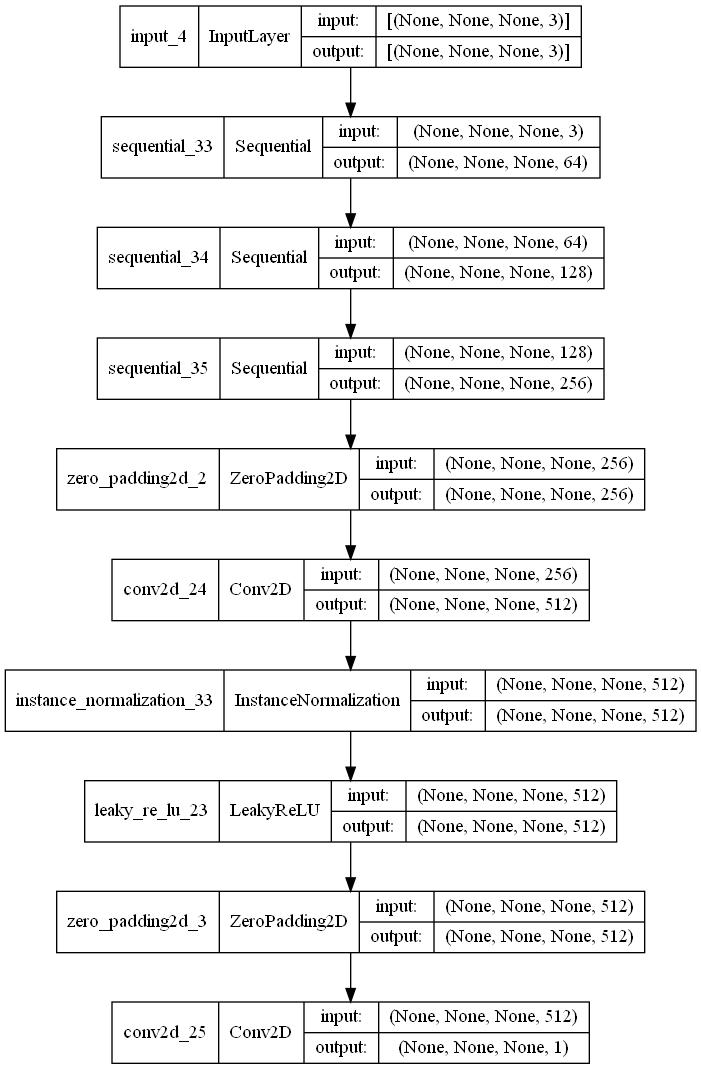

In [46]:
plot_model(cycle_gan.dis_y, show_shapes=True, show_layer_names=True, to_file='cycle_gan.dis_y_summer.jpg')

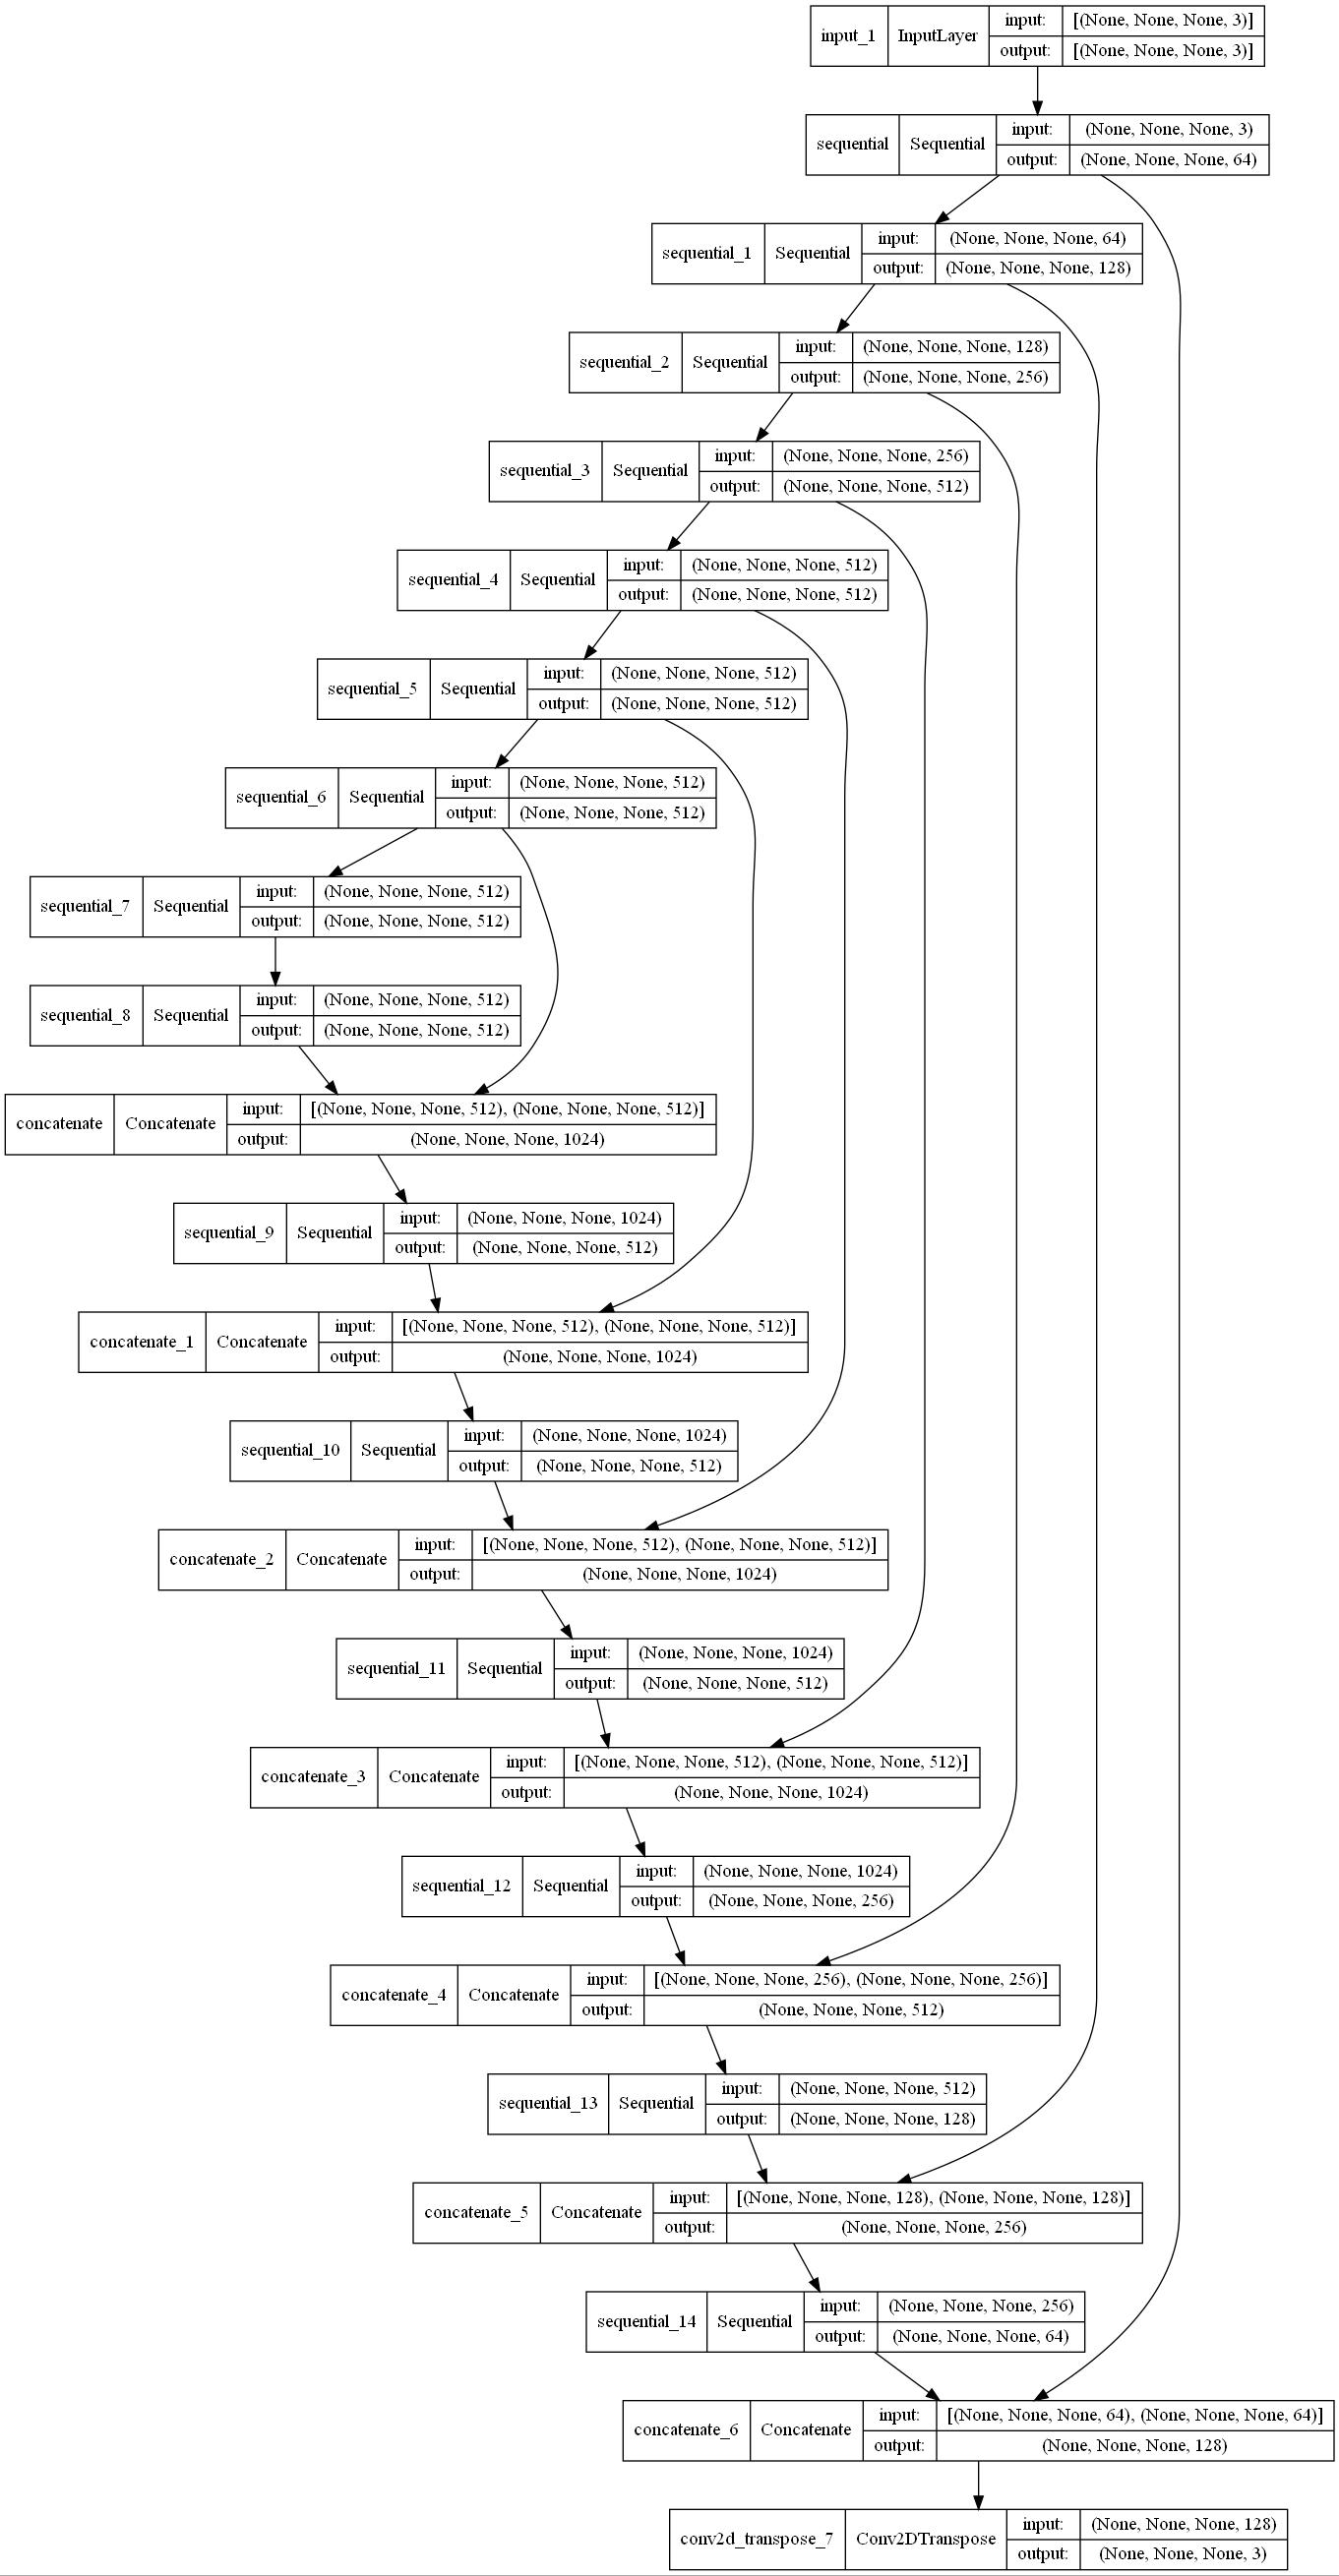

In [47]:
plot_model(cycle_gan.gen_g, show_shapes=True, show_layer_names=True, to_file='cycle_gan.gen_g_summer.jpg')

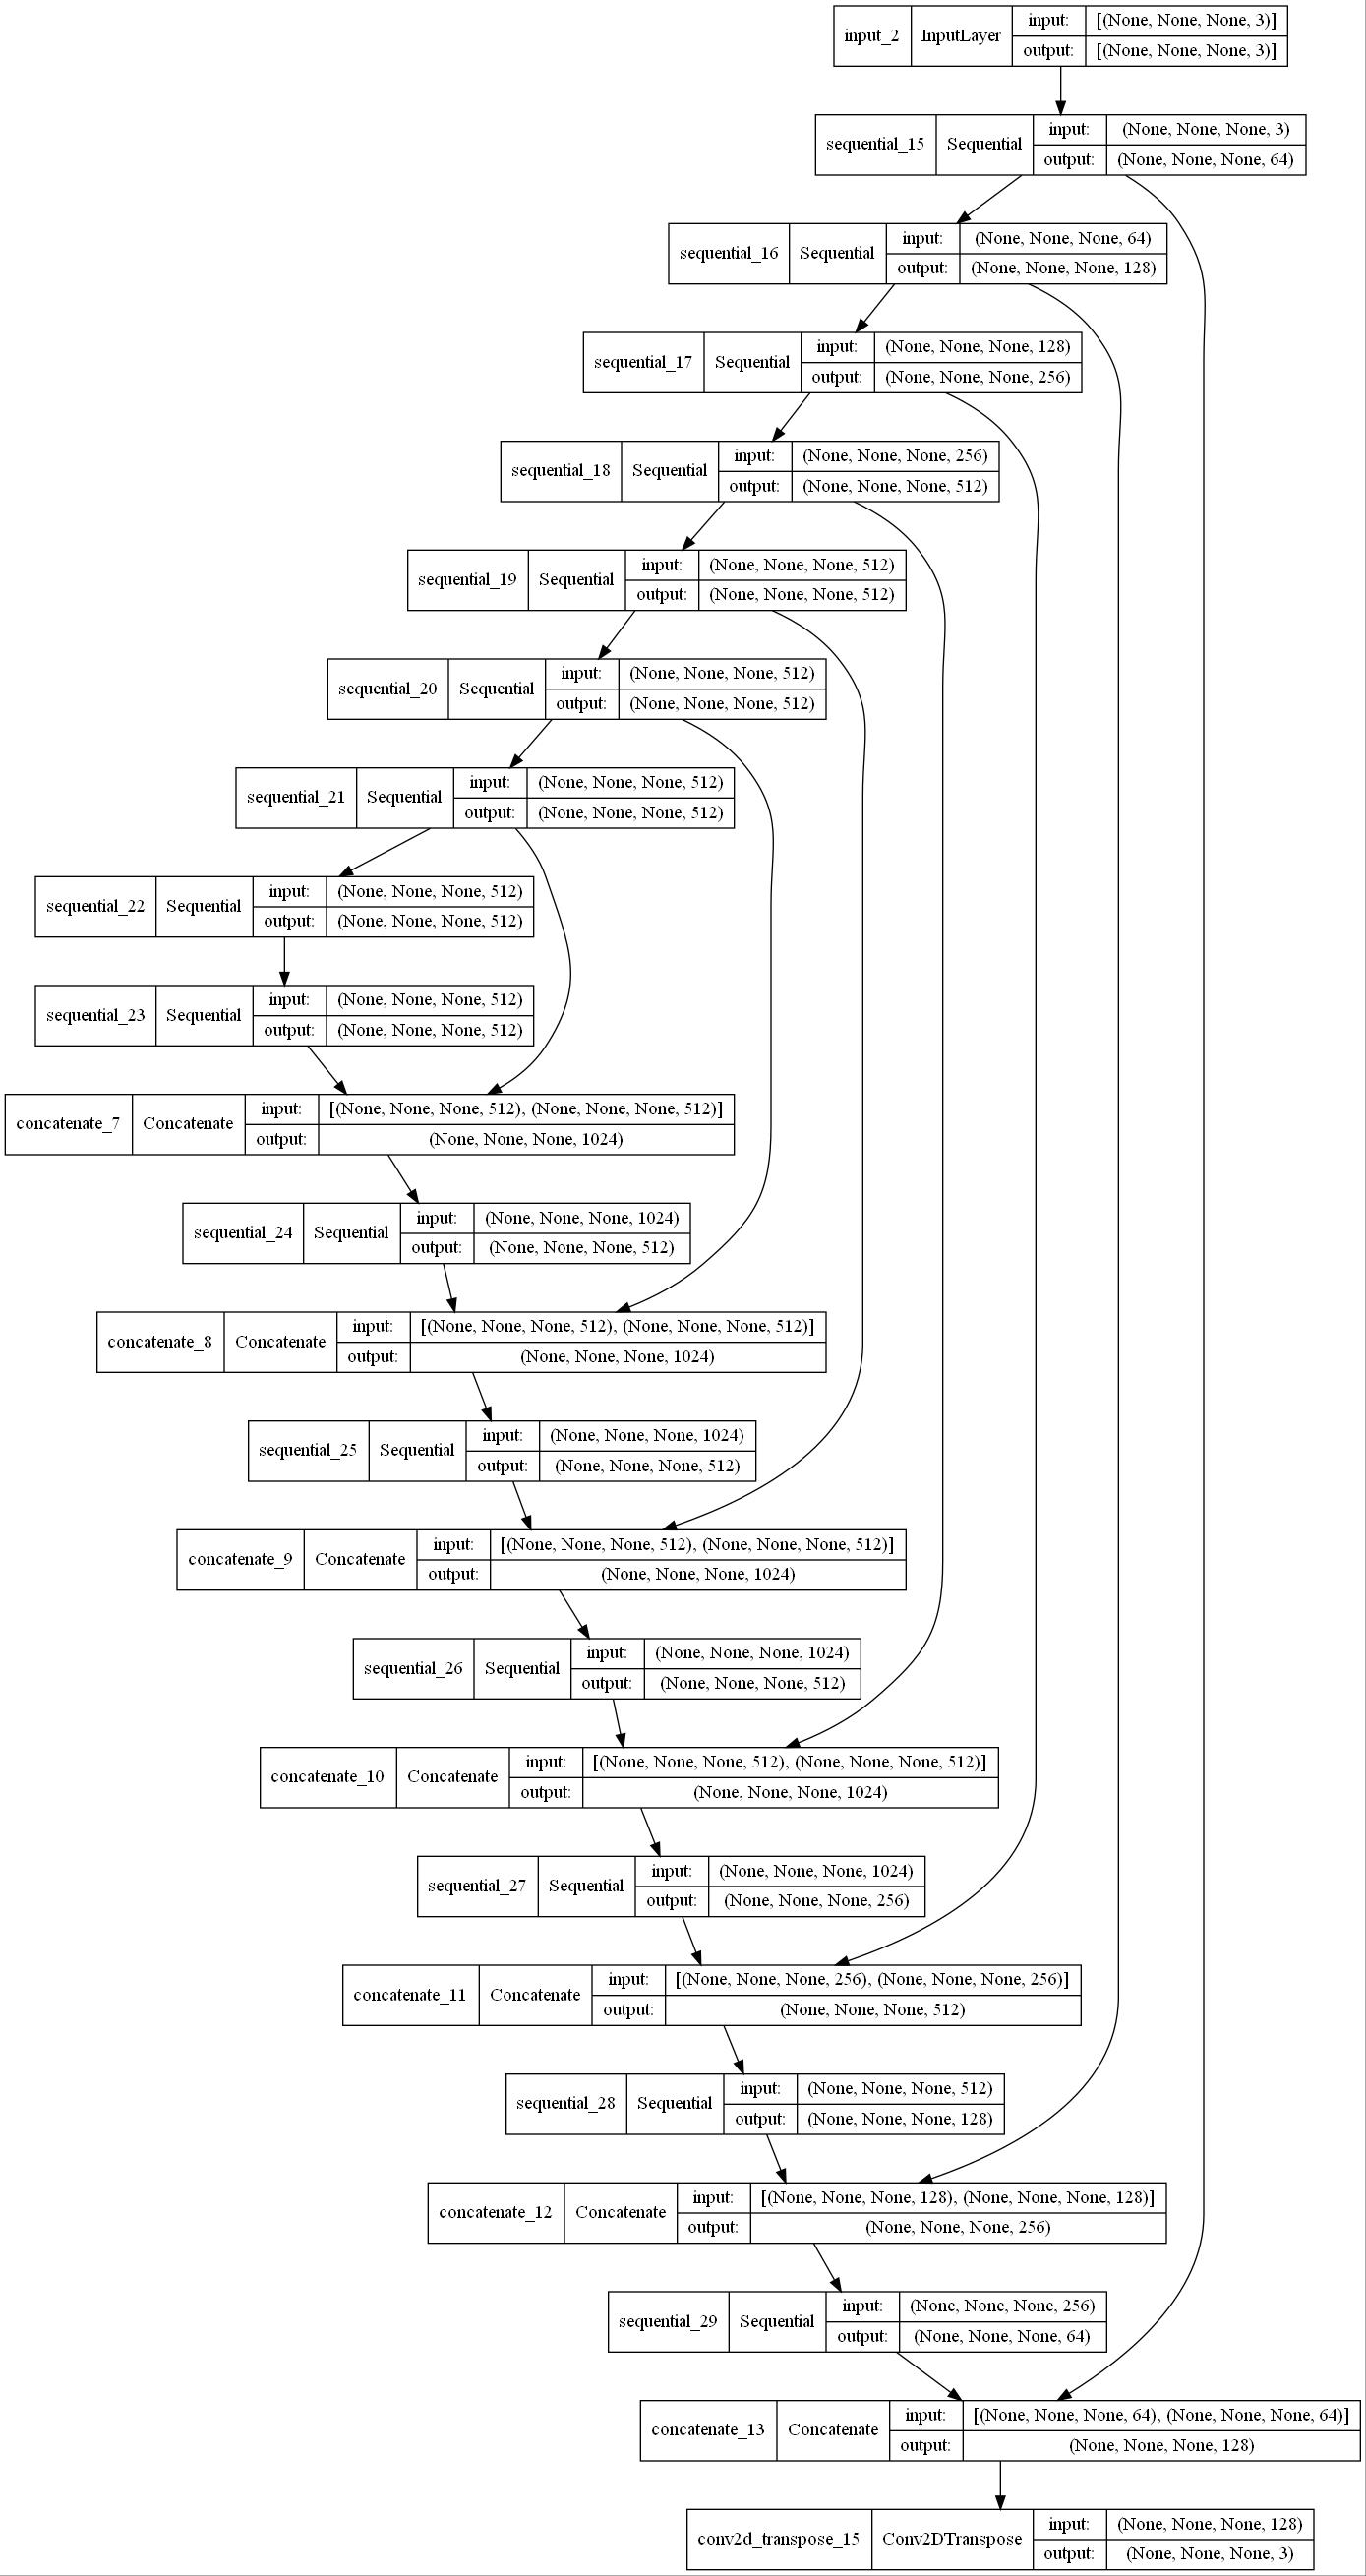

In [48]:
plot_model(cycle_gan.gen_f, show_shapes=True, show_layer_names=True, to_file='cycle_gan.gen_f_summer.jpg')